# Capstone Project: Airbnb Prediciting Prices 
____

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
# Libraries for NPL
from nltk.tokenize import RegexpTokenizer # sent_tokenize, word_tokenize, 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
# Imports similar to Lasso
from sklearn.linear_model import Lasso, LassoCV

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# Reading dataset
listing = pd.read_csv('../data/listings_model.csv')

In [3]:
listing.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words'],
      dtype='object')

# 3. Pre-Processing Data 
____

Check Distribution Data 
Check Outliers
Visualizations:
    - Barcharts by accomodation type
    - Scatter plot price acomodation (type accomodation legend) (?)
    - Map location lat/log (Folium) (?)
    - Time/price (?)     


In [4]:
listing.shape

(22183, 23)

In [5]:
listing['room_type'].value_counts()

Entire home/apt    11942
Private room        9843
Shared room          336
Hotel room            62
Name: room_type, dtype: int64

In [6]:
listing[listing['room_type']=='Private room']

,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,...,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft,description_count,description_words
0,0,"['email', 'phone']",1,1,kensington,Brooklyn,40.645290,-73.972380,Private room,2,...,30,730,9,4.89,0,shared,1.0,2.77,165,"['Renovated', 'apt', 'home', 'in', 'elevator',..."
1,1,"['email', 'phone']",1,1,bedford-stuyvesant,Brooklyn,40.685350,-73.955120,Private room,2,...,30,730,50,4.52,0,private,0.0,2.83,447,"['One', 'room', 'available', 'for', 'rent', 'i..."
4,0,"['email', 'phone']",1,1,east village,Manhattan,40.723220,-73.986150,Private room,2,...,2,60,207,4.34,0,shared,1.5,5.71,966,"['This', 'room', 'is', 'up', 'three', 'flights..."
5,1,"['email', 'phone', 'work_email']",1,1,greenpoint,Brooklyn,40.737770,-73.953660,Private room,4,...,2,365,9,4.67,0,private,1.0,3.83,514,"['This', 'Loft', 'Suite', 'with', 'a', 'Privat..."
6,0,"['email', 'phone']",1,1,upper west side,Manhattan,40.803800,-73.967510,Private room,1,...,2,14,118,4.91,0,shared,1.0,5.53,866,"['Our', 'best', 'guests', 'are', 'seeking', 'a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22166,0,"['email', 'phone', 'work_email']",1,1,central park,Manhattan,40.798400,-73.959720,Private room,2,...,30,60,7,4.00,0,shared,3.0,7.53,181,"['A', 'Private', 'Bedroom', 'Full', 'Size', 'B..."
22169,1,"['email', 'phone']",1,1,central park,Manhattan,40.796970,-73.959410,Private room,3,...,3,31,441,4.55,1,private,1.0,7.53,352,"['Sunny', 'room', 'across', 'from', 'Central',..."
22172,0,"['email', 'phone', 'work_email']",1,1,central park,Manhattan,40.797010,-73.959610,Private room,2,...,30,31,118,4.67,0,private,1.0,7.53,61,"['he', 'spaceMy', 'bedroom', 'is', 'the', 'onl..."
22178,0,"['email', 'phone']",1,0,rosedale,Queens,40.650550,-73.724920,Private room,2,...,7,1125,6,4.83,0,private,1.0,2.41,471,"['I', 'd', 'love', 'to', 'share', 'my', 'split..."


In [7]:
df  = listing.copy()
# Running model only on Private room
#df = listing[listing['room_type']=='Private room']

In [8]:
df.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words'],
      dtype='object')

In [9]:
df.drop( columns=['host_verifications', 'neighbourhood_group_cleansed','beds',
                'latitude', 'longitude', 'description_words', 'description_count' ], 
         inplace=True)

In [10]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft'],
      dtype='object')

In [11]:
df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft
0,0,1,1,kensington,Private room,2,1.0,299.0,30,730,9,4.89,0,shared,1.0,2.77
1,1,1,1,bedford-stuyvesant,Private room,2,1.0,60.0,30,730,50,4.52,0,private,0.0,2.83
2,0,1,1,sunset park,Entire home/apt,4,2.0,275.0,21,1125,3,5.00,0,private,1.5,2.31
3,1,1,1,greenpoint,Hotel room,2,1.0,308.0,2,365,42,4.90,0,private,1.0,3.83
4,0,1,1,east village,Private room,2,1.0,55.0,2,60,207,4.34,0,shared,1.5,5.71


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22183 entries, 0 to 22182
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       22183 non-null  int64  
 1   host_has_profile_pic    22183 non-null  int64  
 2   host_identity_verified  22183 non-null  int64  
 3   neighbourhood_cleansed  22183 non-null  object 
 4   room_type               22183 non-null  object 
 5   accommodates            22183 non-null  int64  
 6   bedrooms                22183 non-null  float64
 7   price                   22183 non-null  float64
 8   minimum_nights          22183 non-null  int64  
 9   maximum_nights          22183 non-null  int64  
 10  number_of_reviews       22183 non-null  int64  
 11  review_scores_rating    22183 non-null  float64
 12  instant_bookable        22183 non-null  int64  
 13  bathrooms_type          22183 non-null  object 
 14  bathrooms_nbr           22183 non-null

## 3.1. Dummifying

In [13]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft'],
      dtype='object')

In [14]:
# Setting category columns to Dummify
col_dummies = ['neighbourhood_cleansed', 'bathrooms_type', 'room_type'] #'neighbourhood_group_cleansed',

In [15]:
df.shape

(22183, 16)

In [16]:
df = pd.get_dummies(df, prefix_sep="__", columns = col_dummies, drop_first = True);

In [17]:
df.shape

(22183, 170)

In [18]:
df.to_csv('../data/listing_preprocess.csv', index=False)

## 3.2. Creating X and y 

In [19]:
X = df.drop(columns='price')
y = np.log(df['price'])
print(X.shape)
print(y.shape)

(22183, 169)
(22183,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
        X,  
        y,
        test_size = 0.2,     
        random_state = 42
 )

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17746, 169), (4437, 169), (17746,), (4437,))

## 3.3. Scaling Data

In [22]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# 4. Machine Learning Models
____

## 4.1. Baseline Model

In [23]:
#Setting a Baseline and getting its Score
baseline_model = [y_train.mean()] * len(y_test)
r2_score(y_test, baseline_model)

-0.000149248367701027

### Fitting Regression Model
___

In [24]:
#Fitting Model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [25]:
#Cross Vaditadion Score
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()
# -3.3924557963554062e+25

-3.86640188244527e+25

In [26]:
# Calcuate residual
lr_y_preds = np.exp(lr.predict(X_train_sc))
residuals = y_train - lr_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lr_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lr_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lr_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lr_y_preds)}')
#MAE: 129.81014920371308
#MSE: 21210.975157781893
#RMSE: 145.63988175558882
#R2: -55534.009329901186

MAE: 129.53814126938332
MSE: 21100.998939397694
RMSE: 145.26182891385366
R2: -55246.06734380193


In [27]:
#Comparing scores
print(f'Train set: {lr.score(X_train_sc, y_train)}')
print(f'Test set: {lr.score(X_test_sc, y_test)}')
print(f'Diference (train/test): {lr.score(X_train_sc, y_train)-lr.score(X_test_sc, y_test)}')

#Train set: 0.6306346195368164
#Test set: -3.790486871672232e+20
#Diference (train/test): 3.790486871672232e+20


Train set: 0.6305454583940859
Test set: -3.5962422910281025e+21
Diference (train/test): 3.5962422910281025e+21


In [28]:
# Creating a list of coeficients
list_coef = list(zip( lr.coef_, X.columns))

In [29]:
# Turn it into a data frame
pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefficient'])

,Coefficient
host_is_superhost,5.901862e-02
host_has_profile_pic,-7.588867e-03
host_identity_verified,1.258704e-02
accommodates,1.347166e-01
bedrooms,6.291107e-02
...,...
neighbourhood_cleansed__woodside,-1.048970e+10
bathrooms_type__shared,-7.888898e-02
room_type__Hotel room,1.845003e-02
room_type__Private room,-1.981481e-01


### Residuals
___

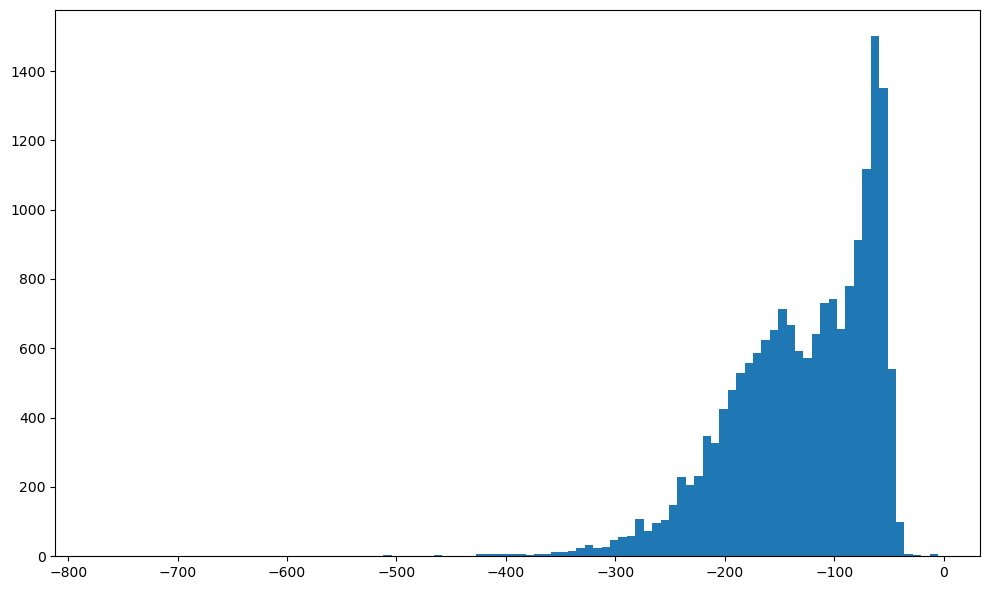

In [30]:
# Normality assumption 
plt.figure(figsize = (10, 6))
plt.hist(residuals, bins = 100);
plt.tight_layout()

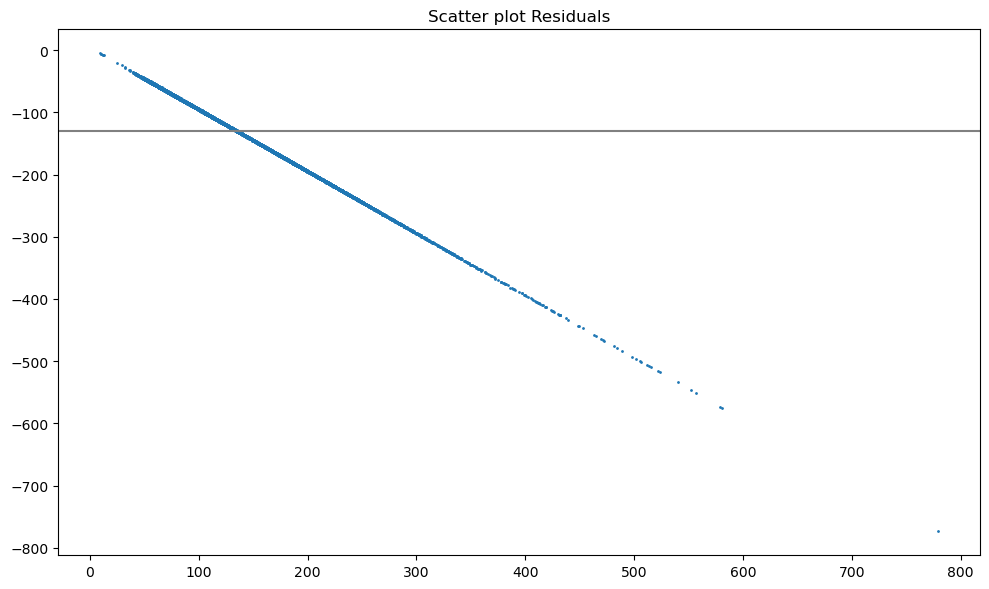

In [31]:
# Normality assumption 
plt.figure(figsize = (10,6))
plt.title("Scatter plot Residuals")
#Ploting Residuals - Scatter Plotf SLR Model 
plt.scatter(lr_y_preds, residuals,s=1);
plt.axhline(residuals.mean(), color='grey');
plt.tight_layout()

## 4.2. Lasso Regularization

In [32]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [33]:
# Here is the optimal value of alpha
print("Best Value of alpha: ",lasso_cv.alpha_)

# Scores on Train a
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))

Best Value of alpha:  0.0015199110829529332
Lasson Train Score:  0.62973809438418
Lasso Test Score 0.621378950889123


In [34]:
# Calcuate residual
lasso_y_preds = np.exp(lasso_cv.predict(X_train_sc))
residuals = y_train - lasso_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lasso_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lasso_y_preds)}')

MAE: 129.4086722199961
MSE: 20978.464789897225
RMSE: 144.83944486878298
R2: -54925.24592540319


## 4.3. Ridge Regularization

In [35]:
# Instantiate.
ridge = Ridge(alpha = 100)

# Fit.
ridge.fit(X_train_sc, y_train)

# Evaluate model using R2.
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')

Training Score: 0.630583788729614
Testing Score: 0.6197607127072771


In [36]:
# Calcuate residual
ridge_y_preds = np.exp(ridge.predict(X_train_sc))
residuals = y_train - ridge_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, ridge_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, ridge_y_preds)}')

MAE: 129.65617947064183
MSE: 21130.867800913667
RMSE: 145.3646029847489
R2: -55324.270608414896


## 4.4. KNNeighbors Regressor


In [37]:
from sklearn.neighbors import KNeighborsRegressor

In [38]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# define the grid search
knn_grid= GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5, verbose = -1)
knn_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             verbose=-1)

In [39]:
knn_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}

In [40]:
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')

# Calcuate residual
knn_grid_y_preds = np.exp(knn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - knn_grid_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_grid_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_grid_y_preds)}')

Training Score: 0.7070238643436905
Testing Score: 0.632221657420106
MAE: 129.77731098099792
MSE: 21210.334179217047
RMSE: 145.63768117907208
R2: -55532.33110670239


In [41]:
knn = KNeighborsRegressor(n_neighbors=5, p=2)
knn.fit(X_train_sc, y_train)

print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')

# Calcuate residual
knn_y_preds = np.exp(knn.predict(X_train_sc))
residuals = y_train - knn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_y_preds)}')

Training Score: 0.7432309863068621
Testing Score: 0.6152923436427763
MAE: 131.52203923610276
MSE: 22137.208496660474
RMSE: 148.78578055936822
R2: -57959.09241701309


## 4.5. CART 

In [45]:
# Import model.
from sklearn.tree import DecisionTreeRegressor

In [46]:
# Instantiate model with:
# - a maximum depth of .
# - at least  samples required in order to split an internal node.
# - at least  samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt_params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
}

dt_grid = GridSearchCV(
                    estimator = DecisionTreeRegressor(random_state=42),
                    param_grid = dt_params,
                    cv = 5,
                    verbose = 1)

# GridSearch!
dt_grid.fit(X_train_sc, y_train)

# What is our best decision tree?
print("Best Estimator: ", dt_grid.best_estimator_)

# What was the cross-validated score of the above decision tree?
print("Best Score: ", dt_grid.best_score_)

# Evaluate model.
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Estimator:  DecisionTreeRegressor(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                      min_samples_split=5, random_state=42)
Best Score:  0.6126533778513967
Score on training set: 0.6201960388099407
Score on testing set: 0.6115041846541385


In [47]:
# Calcuate residual
dt_y_preds = np.exp(dt_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - dt_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, dt_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, dt_y_preds)}')

MAE: 129.04832103818902
MSE: 20406.19181880379
RMSE: 142.85024262773862
R2: -53426.90911851365


## 4.6. Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [49]:
# Taking 47 min to run
# Gridsearch Parameters
rf_params = {
    'n_estimators': [200, 250, 300, 400],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth' : [None, 3, 4, 5, 6],
    'n_jobs': [-1]
}
# Setting Gridsearch
rf_grid = GridSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = rf_params, 
    cv = 5
)
# Fitting Model
rf_grid.fit(X_train_sc, y_train)

# Printing Outputs
print(f'Best Score : {rf_grid.best_score_}')
print(f'Best Parameters: {rf_grid.best_params_}') 
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')

Best Score : 0.686679645780948
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200, 'n_jobs': -1}
Score on training set: 0.8471344136556207
Score on test set: 0.6877649397746577


In [50]:
# Calcuate residual
rf_y_preds = np.exp(rf_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - rf_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, rf_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, rf_y_preds)}')

MAE: 132.01703660770173
MSE: 22319.21480862454
RMSE: 149.3961673157131
R2: -58435.62506852189


## 4.7. Neural Network

In [51]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, Input

Init Plugin
Init Graph Optimizer
Init Kernel


In [52]:
def model_fn(h1_neurons = 32, h2_neurons=32, drop = 0.5):
  
  print(f'h1: {h1_neurons}, h2: {h2_neurons}, drop: {drop}')
  
  inputs = Input(shape = (X_train_sc.shape[1],))
  
  h1 = Dense(h1_neurons, activation = 'relu')(inputs)
  d1 = Dropout(drop)(h1)
  
  h2 = Dense(h2_neurons, activation = 'relu')(d1)
  out = Dense(1, activation = None)(h2)

  model = Model(inputs = inputs, outputs = out)

  model.compile(loss = 'mse',
                optimizer = 'adam', 
                metrics='acc')
  
  return model

In [53]:
# kind of like when lr = LinearRegression()
nn = KerasRegressor(build_fn = model_fn, batch_size = 256, verbose = 0)

In [54]:
params = {
    'epochs': [100],
    'h1_neurons': [16, 64, 128],
    'h2_neurons': [64, 128],
    'drop':[0.1,0.25, 0.5]
}

In [55]:
# 19 min to run
nn_grid = GridSearchCV(nn, param_grid = params, cv = 3)
nn_grid.fit(X_train_sc, y_train)

h1: 16, h2: 64, drop: 0.1
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-11 10:50:08.572473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 10:50:08.572603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-11 10:50:08.705779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-11 10:50:08.709206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-11 10:50:08.968485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:50:27.306827: I tensorflow/core/grappler/

h1: 16, h2: 64, drop: 0.1


2022-11-11 10:50:27.568400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:50:45.681464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-11 10:50:45.937724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:51:03.815919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-11 10:51:04.088066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:51:21.960040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-11 10:51:22.218360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:51:40.877908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-11 10:51:41.133751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:51:59.591377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-11 10:51:59.855959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:52:18.426758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-11 10:52:18.687880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:52:37.192430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-11 10:52:37.453909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:52:55.756596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-11 10:52:56.023123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:53:14.561875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-11 10:53:14.821821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:53:33.178358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-11 10:53:33.436809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:53:51.851907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-11 10:53:52.117971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:54:10.408586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-11 10:54:10.669561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:54:29.029740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-11 10:54:29.288676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:54:47.790483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-11 10:54:48.328084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:55:06.911693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-11 10:55:07.170410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:55:25.497823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-11 10:55:25.757412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:55:44.197670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-11 10:55:44.458639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:56:02.747984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-11 10:56:03.017119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:56:21.479990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-11 10:56:21.981229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:56:40.319888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-11 10:56:40.581888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:56:59.132090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-11 10:56:59.394695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:57:17.810093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-11 10:57:18.072434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:57:36.446871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-11 10:57:36.708628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:57:54.965934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-11 10:57:55.477773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:58:13.735399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-11 10:58:13.994814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:58:32.400529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-11 10:58:32.660769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:58:50.946018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-11 10:58:51.208518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:59:09.628725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-11 10:59:09.894623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:59:28.260751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-11 10:59:28.769986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 10:59:47.130021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-11 10:59:47.422142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:00:05.846915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-11 11:00:06.116282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:00:24.522956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-11 11:00:24.785145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:00:43.367202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-11 11:00:43.640104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:01:01.922120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-11 11:01:02.436736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:01:21.235760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-11 11:01:21.500472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:01:39.934895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-11 11:01:40.224773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:01:59.120882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-11 11:01:59.407457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:02:18.118938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-11 11:02:18.389166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:02:37.050918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-11 11:02:37.629627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:02:56.722740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-11 11:02:56.989657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:03:15.684004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-11 11:03:15.953089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:03:34.818570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-11 11:03:35.090969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:03:53.765393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-11 11:03:54.041387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:04:12.919844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-11 11:04:13.191285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:04:31.860626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-11 11:04:32.438640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:04:51.638770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-11 11:04:51.908304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:05:10.724347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-11 11:05:10.994149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:05:29.849565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-11 11:05:30.123020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:05:48.895260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-11 11:05:49.170707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:06:08.034837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-11 11:06:08.546316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:06:27.379766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-11 11:06:27.651997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:06:46.661310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-11 11:06:46.935038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-11 11:07:05.969955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-11 11:07:06.249512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1725bc280>,
             param_grid={'drop': [0.1, 0.25, 0.5], 'epochs': [100],
                         'h1_neurons': [16, 64, 128], 'h2_neurons': [64, 128]})

In [56]:
print(f'Best Score: {nn_grid.best_score_}')
print(f'Best parameters: {nn_grid.best_params_}')

Best Score: -0.14542769392331442
Best parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 64}


In [57]:
# Printing Outputs
print(f'Best Score : {nn_grid.best_score_}')
print(f'Best Parameters: {nn_grid.best_params_}') 
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')

Best Score : -0.14542769392331442
Best Parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 64}


2022-11-11 11:07:34.126276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Score on training set: -0.11573432385921478
Score on test set: -0.1335896998643875


In [58]:
# Calculate residual
nn_y_preds = np.exp(nn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - nn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, nn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, nn_y_preds)}')

MAE: 121.64584283936328
MSE: 18382.04402790381
RMSE: 135.58039691601365
R2: -48127.24393968344


2022-11-11 11:07:34.559875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## 4.8. Stacking 


Getting the predictions from models (level 1) to use as features for an another model (level 2)

In [59]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [60]:
X_pred_train = pd.DataFrame(index = X_train.index)

X_pred_train['model_rf'] = rf_grid.best_estimator_.predict(X_train_sc) # Radom Forest Model Predictions
X_pred_train['model_dt'] = dt_grid.best_estimator_.predict(X_train_sc) # Decision Trees Model Predictions
X_pred_train['model_ridge'] = ridge.predict(X_train_sc) # Linear Regression Ridge Regulatization Predictions
X_pred_train

,model_rf,model_dt,model_ridge
15719,4.814263,4.800279,4.973356
16666,4.299414,4.347305,4.162147
19747,4.962000,4.800279,4.865896
6705,5.248602,5.019551,5.120827
3143,5.246699,5.133363,5.293105
...,...,...,...
11964,4.953688,5.480400,5.073471
21575,5.265052,5.206672,5.322712
5390,4.783168,4.695968,4.833145
860,5.261342,5.450114,5.444584


In [61]:
stacked_model = LinearRegression()
cross_val_score(stacked_model, X_train_sc, y_train).mean()

-3.86640188244527e+25

In [62]:
# Fit
stacked_model.fit(X_pred_train, y_train)

LinearRegression()

In [63]:
# Train score
stacked_model.score(X_pred_train, y_train)

0.8786293315685025

In [64]:
X_pred_test = pd.DataFrame(index = X_test.index)

X_pred_test['model_rf'] = rf_grid.best_estimator_.predict(X_test_sc) # Radom Forest Model Predictions
X_pred_test['model_dt'] = dt_grid.best_estimator_.predict(X_test_sc)# Decision Trees Model Predictions
X_pred_test['model_ridge'] = ridge.predict(X_test_sc)# Linear Regression Ridge Regulatization Predictions
X_pred_test

,model_rf,model_dt,model_ridge
563,5.028987,5.133363,4.665033
1383,5.227942,5.133363,5.287216
2404,4.101315,4.347305,4.322111
16430,5.327076,5.206672,5.334400
13160,4.093336,4.347305,3.773224
...,...,...,...
8928,4.308394,4.303205,4.369466
7717,5.490676,5.206672,5.414144
8049,5.133830,5.206672,5.023049
20996,4.312437,4.347305,4.313750


In [65]:
# Train score
stacked_model.score(X_pred_test, y_test)

0.6515970674019617

In [66]:
# Calcuate residual
stacked_y_preds = np.exp(stacked_model.predict(X_pred_train))
residuals = y_train - stacked_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, stacked_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, stacked_y_preds)}')

MAE: 135.81047687622765
MSE: 24960.03434714372
RMSE: 157.98744996721643
R2: -65349.87283974905


## 4.9. Stacked Model ElasticNet

In [67]:
from sklearn.linear_model import ElasticNet

In [68]:
from sklearn.linear_model import ElasticNetCV

In [69]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio - the amount of L1 vs L2 penalty. 
# An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.
enet_ratio = 0.01

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_pred_train, y_train)

# Evaluate model.
print(enet_model.score(X_pred_train, y_train))
print(enet_model.score(X_pred_test, y_test))

0.6270532075282034
0.571102346061428


In [70]:
# Calcuate residual
enet_model_preds_train = np.exp(enet_model.predict(X_pred_train))
residuals = y_train - enet_model_preds_train

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, enet_model_preds_train)}')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, enet_model_preds_train)}')

MAE: 120.48291244842405
MSE: 15913.889746751653
RMSE: 126.15026653460409
R2: -41665.07187961516


# 5. Pickling a Model
___

Pickling a model to build a streamlit app.

In [71]:
import pickle

In [72]:
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)